In [49]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

domain = "www.reddit.com/" # <- put your domain to be crawled
full_url = "https://www.reddit.com/" # <- put your domain to be crawled with https or http

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

In [50]:
# Function to get the hyperlinks from a URL
def get_hyperlinks(url):

    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []

            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

In [51]:
# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

In [52]:
def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    q_limit = 10
    count = 0
    while queue:
        if count==q_limit:
            break
        count += 1
        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w", encoding="UTF-8") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")

            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)

https://www.reddit.com/
https://www.reddit.com/search/?q=%22Tim+Sweeney%22&type=link&source=trending&cId=3e327f1a-0a58-42b4-b88f-4fe11a967977&iId=13cf5e18-8643-4512-b367-510e83e59df0
https://www.reddit.com/search/?q=%22Tim+Sweeney%22&type=sr&source=trending&cId=3e327f1a-0a58-42b4-b88f-4fe11a967977&iId=13cf5e18-8643-4512-b367-510e83e59df0
https://www.reddit.com/r/sofi_bagholders
https://www.reddit.com/user/Stoneteer
https://www.reddit.com/r/sportsbook/comments/1fu5j7w/mlb_betting_and_picks_10224_wednesday
https://www.reddit.com/r/sportsbook/comments/wd38a8/general_discussionquestions
https://www.reddit.com/r/sportsbook/comments/1bbus9y/north_carolina_sportsbooks_megathread
https://www.reddit.com/r/sportsbook/?f=flair_name%3A%22State%20Sportsbooks%22
https://www.reddit.com/r/sportsbook/about/rules


In [53]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [54]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r", encoding="UTF-8") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

,fname,text
0,com r 80s ?f=flair name%3A%22Film%22,com r 80s ?f=flair name%3A%22Film%22. Reddit ...
1,com user TinolangEsophagus,com user TinolangEsophagus. Reddit - Dive int...
2,com r olympics comments 1fcmak5 australian bre...,com r olympics comments 1fcmak5 australian bre...
3,com r sportsbook comments 1bbus9y north caroli...,com r sportsbook comments 1bbus9y north caroli...
4,com r fantasyfootball comments 18amo4g cj stro...,com r fantasyfootball comments 18amo4g cj stro...


<Axes: >

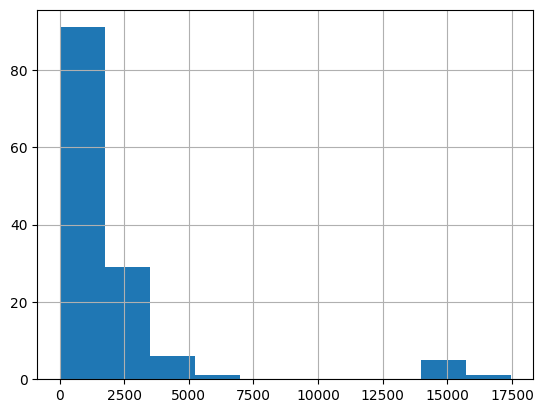

In [55]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [56]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks


shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])

    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<Axes: >

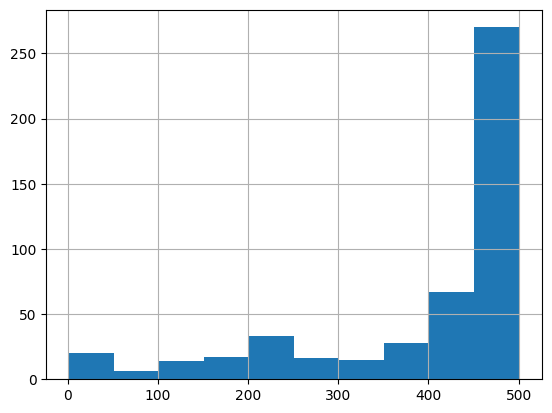

In [57]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [58]:
print (df)

                                                  text  n_tokens
0    com r 80s ?f=flair name%3A%22Film%22.  Reddit ...       316
1    com user TinolangEsophagus.  Reddit - Dive int...       463
2        Members  Online   • What's the most unusua...       463
3        Members  Online   • obey traffic laws at a...       390
4    com r olympics comments 1fcmak5 australian bre...       211
..                                                 ...       ...
481  The goal is to at once embrace, and poke fun a...       153
482  com search ?q=%22Tim+Sweeney%22&type=sr&source...       479
483      r/Games  r/Games  members · online   The g...       469
484      r/pcmasterrace  r/pcmasterrace  members · ...       446
485  com r BridgeCrew top.  Reddit - Dive into anyt...       204

[486 rows x 2 columns]


In [59]:
import openai
import os
import requests

# Load environment variables from the .env file
with open("/Users/jubaidatasnim/GenAi/.env") as env:
    for line in env:
        key, value = line.strip().split("=")
        os.environ[key] = value

# Set the OpenAI API key from environment variables

openai.api_key = os.getenv('API_KEY')
openai.api_key = api_key
# Example usage of embeddings (assuming you have a DataFrame called df)
df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])

# Save the embeddings to a CSV file
df.to_csv('processed/embeddings.csv')

# Display the first few rows
df.head()


,text,n_tokens,embeddings
0,com r 80s ?f=flair name%3A%22Film%22. Reddit ...,316,"[0.0023201224394142628, -0.020780807361006737,..."
1,com user TinolangEsophagus. Reddit - Dive int...,463,"[0.014561430551111698, 0.0049392483197152615, ..."
2,Members Online • What's the most unusua...,463,"[-0.013696198351681232, -0.016805235296487808,..."
3,Members Online • obey traffic laws at a...,390,"[0.007803275249898434, -0.003955921158194542, ..."
4,com r olympics comments 1fcmak5 australian bre...,211,"[-0.025677474215626717, 0.008606936782598495, ..."


In [60]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import distances_from_embeddings

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,com r 80s ?f=flair name%3A%22Film%22. Reddit ...,316,"[0.0023201224394142628, -0.020780807361006737,..."
1,com user TinolangEsophagus. Reddit - Dive int...,463,"[0.014561430551111698, 0.0049392483197152615, ..."
2,Members Online • What's the most unusua...,463,"[-0.013696198351681232, -0.016805235296487808,..."
3,Members Online • obey traffic laws at a...,390,"[0.007803275249898434, -0.003955921158194542, ..."
4,com r olympics comments 1fcmak5 australian bre...,211,"[-0.025677474215626717, 0.008606936782598495, ..."


In [61]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """
    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']
    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')
    
    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():

        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4

        # If the context is too long, break
        if cur_len > max_len:
            break

        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [62]:
def answer_question(
    df,
    model="gpt-3.5-turbo",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    content = "Context: " + context + "\n\n---\n\nQuestion: " + question + "\nAnswer:"
    if debug:
        print("Context:\n" + content)
        print("\n\n")
    try:
        # Create a chat completion using the question and context
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "user", "content": content}
            ],
            temperature=0,
            max_tokens=12,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
        )
        return response.choices[0].message.content
    except Exception as e:
        print(e)
        return ""

In [63]:
df['embeddings']

0      [0.0023201224394142628, -0.020780807361006737,...
1      [0.014561430551111698, 0.0049392483197152615, ...
2      [-0.013696198351681232, -0.016805235296487808,...
3      [0.007803275249898434, -0.003955921158194542, ...
4      [-0.025677474215626717, 0.008606936782598495, ...
                             ...                        
481    [-0.00021810721955262125, -0.03150461241602897...
482    [-0.009907223284244537, 0.0005647385260090232,...
483    [-0.0009849796770140529, -0.000923418439924717...
484    [0.01330981682986021, 0.0023028715513646603, -...
485    [-0.002005205024033785, -0.009879055432975292,...
Name: embeddings, Length: 486, dtype: object

In [64]:
answer_question(df, question="what is reddit", debug=False)

'Reddit is a social news aggregation, web content rating, and'

In [65]:
answer_question(df, question="What day is today", debug=False)

'Today is the day when an asteroid the size of 64'

In [66]:

answer_question(df, question="What is our newest embeddings model?", debug=False)


'Our newest embeddings model is GPT-4.'

In [67]:

answer_question(df, question="What is ChatGPT?", debug=False)

'ChatGPT is a language model developed by OpenAI that'

In [68]:
pip install openai


Note: you may need to restart the kernel to use updated packages.
